In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import matplotlib.pyplot as plt
import sklearn

import xgboost as xgb
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# MODIFY if necessary
subject_id = "02"

number_of_folds = 10

# If true, we ignore neural case and only calssfiy between positive and negative
binary_classification = True

number_of_neighbors = 5


# FOR POWER DATA:
# Frequency bands for power data
power_band = ["alpha", "beta", "delta", "theta"]
# the channel you want to add for the power data
channel = ["AF7", 'AF8']

NORMALIZE_METHODS = "standard_scalar",  # normalizer, "standard_scalar", "MinMax", or None


# DO NOT MODIFY
lower_bound = 10
# Because we are cutting the length of each unit to match the length of power
upper_bound = 550 
power_length = 153

NUM_OF_POWER_COLUMNS = 5

In [3]:
def assign_units_to_folds(df, folds, lower_bound, upper_bound):
    """
    Execute before k-fold cross-validation: extract each unit, assign it to different folds in order
    df: The dataframe that contains data of each patient
    lower_bound: Experiment time's lower bound indicating the beginning of each unit
    upper_bound: Experiment time's upper bound indicating the ending of each unit
    """
    num_folds = len(folds)
    num_rows = len(df)
    j = 1
    i = fold_pointer = 0
    while j <= num_rows - 1:
        prev_time = df.iloc[j-1]["Time"]
        time = df.iloc[j]["Time"]
        # if the time jumps from upper_bound(250) to a time smaller than the lower_bound (-80)
        # we find a unit
        if(time < lower_bound and prev_time > upper_bound):
            unit = df.iloc[i:j]
            folds[fold_pointer].append(unit)
            fold_pointer = (fold_pointer + 1) % num_folds
            i = j
        j = j + 1
    last_unit = df.iloc[i : j]
    folds[fold_pointer].append(last_unit)
    
def concat_dataframes(fold_list, remove_columns_names):
    """
    concatenate lists of dataframes to one dataframe and drop the specified columns if needed
    fold_list: a list of folds 
    remove_columns_names: a list of names of columns you want to exclude
    """
    folds_concat = []
    for fold in fold_list:
        folds_concat.append(pd.concat(fold, ignore_index=True).drop(columns=remove_columns_names))
    return folds_concat

def get_features(subject_data):
    column_names = subject_data.columns
    alpha_columns = [i for i in column_names if "alpha" in i]
    beta_columns = [i for i in column_names if "beta" in i]
    theta_columns = [i for i in column_names if "theta" in i]
    
    alpha = subject_data.loc[:, alpha_columns]
    beta = subject_data.loc[:, beta_columns]
    theta = subject_data.loc[:, theta_columns]
    
    alpha_std = np.std(alpha, axis=1)
    beta_std = np.std(beta, axis=1)
    theta_std = np.std(theta, axis=1)
    
    alpha_mean = np.mean(alpha, axis=1)
    beta_mean = np.mean(beta, axis=1)
    theta_mean = np.mean(theta, axis=1)
    
    #Concate feature
    feature = np.array([theta_std,theta_mean,alpha_std,alpha_mean,beta_std,beta_mean])
    feature = feature.T

    return feature

def match_power(df, df_power, index):
    """
    df: The frequency dataframe
    df_power: The power dataframe
    index: the starting index of power name
    """
    num_columns = len(df_power.columns)
    assert num_columns == NUM_OF_POWER_COLUMNS
    res = pd.DataFrame()
    zero_idx = df.index[df['Time'] == 0].tolist()
    for idx in zero_idx:
        df_temp = df.iloc[idx:idx + power_length + 1, :]
        res = pd.concat([res, df_temp], axis=0)
    res = res.reset_index()
    assert len(res) == len(df_power)
    column_names = [f"Power{i}" for i in range(index, index+num_columns)]
    df_power = df_power.set_axis(column_names, axis=1)
           
    df_res = pd.concat([res, df_power], axis=1)
    return df_res

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.rcParams.update({'font.size': 5})
    plt.tick_params(axis='y', labelsize=5)
    plt.savefig(f'output/subject_{subject_id}/{subject_id}_LSVM_FeatureImportance.png', dpi=2000, bbox_inches="tight")
    plt.show()

In [4]:
# Read negative, neutral, and positive data from data folder
states = ["negative", "neutral", "positive"]
bands = ["alpha", "beta", "delta", "theta"]
neg_neu_pos = []
    
for state in states:
    df = pd.DataFrame()
    for band in bands:
        df_temp = pd.read_csv(f"data_newcut/subject_{subject_id}/{subject_id}_processed_{state}_flt_{band}.csv")
        df_temp = df_temp.rename(columns={"TP9":f"TP9_{band}",
                                          "AF7":f"AF7_{band}",
                                          "AF8":f"AF8_{band}",
                                          "TP10":f"TP10_{band}"})
        # remove the time column for beta and theta
        if band in ["beta", "theta", "delta"]:
            df_temp = df_temp.drop([f"Time"], axis=1)
        
        df = pd.concat([df, df_temp], axis=1)
        
    # Remove times that are smaller than 0
    df = df[df['Time'] >= 0].reset_index(drop=True)
    neg_neu_pos.append(df)

In [5]:
# states are the same as the previous ones: "negative", "neutral", "positive"
for i, state in enumerate(states):
    s_state = neg_neu_pos[i]
    power_idx = 1
    for band in power_band:
        for cn in channel:
            tmp_power = pd.read_csv(f"data_newcut/Power/subject_{subject_id}/{subject_id}_processed_{state}_flt_{band}_{cn}_power.csv", header = None)
            tmp_power = tmp_power.transpose()

            s_state = match_power(s_state, tmp_power, power_idx)
            lst_column = [i for i in range(power_idx, power_idx + NUM_OF_POWER_COLUMNS)]
            s_state = s_state.drop(columns = ["index"])
            
            # Add average of the previous five power columns
            s_state[f"avg_{band}_power_{cn}"] = s_state.iloc[:, -NUM_OF_POWER_COLUMNS:].sum(axis=1) / NUM_OF_POWER_COLUMNS
            power_idx = power_idx + NUM_OF_POWER_COLUMNS
            
    neg_neu_pos[i] = s_state
subject_negative = neg_neu_pos[0]
subject_neutral = neg_neu_pos[1]
subject_positive  = neg_neu_pos[2]

In [6]:
subject_negative

,Time,TP9_alpha,AF7_alpha,AF8_alpha,TP10_alpha,TP9_beta,AF7_beta,AF8_beta,TP10_beta,TP9_delta,...,Power33,Power34,Power35,avg_theta_power_AF7,Power36,Power37,Power38,Power39,Power40,avg_theta_power_AF8
0,0.0000,7.9576,0.9946,3.0975,7.2975,2.1485,2.4212,5.2811,0.9987,-24.2366,...,2.239024,2.193635,2.338128,2.236959,0.013339,0.056409,0.040311,0.065432,0.069656,0.049029
1,3.9063,8.3554,0.8533,1.7680,6.7223,1.1406,3.2227,4.1767,0.4814,-26.5276,...,2.250973,2.223191,2.410613,2.247330,0.028861,0.070331,0.048410,0.070389,0.073784,0.058355
2,7.8125,8.3624,0.5896,0.3334,5.7911,-0.2499,3.2848,1.7297,-1.5274,-28.8168,...,2.309587,2.298324,2.513922,2.303662,0.049168,0.089092,0.059734,0.078108,0.080449,0.071310
3,11.7188,7.9803,0.2436,-1.1211,4.5862,-0.9807,2.6525,-1.0906,-4.0042,-31.0964,...,2.417458,2.419578,2.645161,2.408975,0.072710,0.111420,0.072617,0.086658,0.087446,0.086170
4,15.6250,7.2332,-0.1354,-2.5078,3.2059,-0.5371,1.5337,-3.3031,-5.5102,-33.3582,...,2.573109,2.583752,2.799217,2.562235,0.097765,0.136077,0.085600,0.094426,0.093017,0.101377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15857,582.0313,3.2380,0.8522,-0.7435,-0.5009,4.9508,0.2301,-6.0249,-7.7777,1.3006,...,0.362301,0.372692,0.397234,0.334690,1.113590,1.073170,0.813458,0.769224,0.717622,0.897413
15858,585.9375,3.9707,1.7734,-0.1137,1.6201,7.7190,-0.1602,-4.0003,-3.6998,1.2833,...,0.337199,0.344838,0.372043,0.311206,1.131723,1.089133,0.824296,0.774770,0.719463,0.907877
15859,589.8438,4.3574,2.5023,0.4620,3.7098,8.5512,0.5401,-1.1481,1.9249,1.2674,...,0.320605,0.326105,0.354259,0.295900,1.119868,1.096307,0.823786,0.772054,0.719403,0.906284
15860,593.7500,4.4055,2.9982,0.9625,5.6208,7.0287,1.6784,1.3224,7.2622,1.2534,...,0.312838,0.316825,0.344156,0.289100,1.079703,1.095362,0.813126,0.762406,0.718698,0.893859


In [7]:
# psd = pd.read_csv(f"data_newcut/subject_{subject_id}/{subject_id}_PSD.csv", header = None)
# psd = psd.transpose()

In [8]:
# Suppose negative = 0; positive = 1; and neutral = 2; 
subject_negative["y"] = 0
subject_neutral["y"] = 2
subject_positive["y"] = 1

# Concatenate all three datasets
subject_data = pd.concat([subject_negative, subject_neutral, subject_positive], ignore_index=True)

subject_data = subject_data.reset_index(drop=True)

In [9]:
subject_data

,Time,TP9_alpha,AF7_alpha,AF8_alpha,TP10_alpha,TP9_beta,AF7_beta,AF8_beta,TP10_beta,TP9_delta,...,Power34,Power35,avg_theta_power_AF7,Power36,Power37,Power38,Power39,Power40,avg_theta_power_AF8,y
0,0.0000,7.9576,0.9946,3.0975,7.2975,2.1485,2.4212,5.2811,0.9987,-24.2366,...,2.193635,2.338128,2.236959,0.013339,0.056409,0.040311,0.065432,0.069656,0.049029,0
1,3.9063,8.3554,0.8533,1.7680,6.7223,1.1406,3.2227,4.1767,0.4814,-26.5276,...,2.223191,2.410613,2.247330,0.028861,0.070331,0.048410,0.070389,0.073784,0.058355,0
2,7.8125,8.3624,0.5896,0.3334,5.7911,-0.2499,3.2848,1.7297,-1.5274,-28.8168,...,2.298324,2.513922,2.303662,0.049168,0.089092,0.059734,0.078108,0.080449,0.071310,0
3,11.7188,7.9803,0.2436,-1.1211,4.5862,-0.9807,2.6525,-1.0906,-4.0042,-31.0964,...,2.419578,2.645161,2.408975,0.072710,0.111420,0.072617,0.086658,0.087446,0.086170,0
4,15.6250,7.2332,-0.1354,-2.5078,3.2059,-0.5371,1.5337,-3.3031,-5.5102,-33.3582,...,2.583752,2.799217,2.562235,0.097765,0.136077,0.085600,0.094426,0.093017,0.101377,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34491,582.0313,0.3204,-2.0608,-2.5077,0.4636,-11.7122,-7.6323,-6.5322,-5.3802,2.3305,...,2.560328,2.783271,2.373375,0.442593,0.639383,0.702487,0.697887,0.752336,0.646937,1
34492,585.9375,-2.5715,-1.2753,-2.6235,1.3036,-11.7751,-7.1906,-2.0169,-1.8097,1.7813,...,2.505693,2.738155,2.325508,0.491863,0.650680,0.733894,0.731092,0.778837,0.677273,1
34493,589.8438,-5.1916,-0.3991,-2.4894,2.0563,-10.0527,-4.2406,1.8017,2.7353,1.2318,...,2.515883,2.742153,2.338187,0.565152,0.668660,0.781219,0.781077,0.819017,0.723025,1
34494,593.7500,-7.3666,0.5011,-2.1157,2.6560,-7.4963,0.1014,4.1359,6.3806,0.6837,...,2.589053,2.793841,2.409769,0.657903,0.692076,0.841495,0.844800,0.870484,0.781352,1


In [10]:
feature = get_features(subject_data)
df_newFeature = pd.DataFrame(feature, columns = ['theta_std','theta_mean','alpha_std',
                                                 'alpha_mean','beta_std','beta_mean'
                                                ])
df = pd.concat([subject_data, df_newFeature], axis=1)

In [11]:
y_column = df.pop("y")

In [12]:
column_names = df.columns

In [13]:
cols = df.columns[df.columns != 'Time']
if NORMALIZE_METHODS == "normalizer":
    df[cols] = sklearn.preprocessing.normalize(df[cols], axis=0)
elif NORMALIZE_METHODS == "standard_scalar":
    df[cols] = sklearn.preprocessing.scale(df[cols]),
elif NORMALIZE_METHODS == "MinMax":
    df[cols] = sklearn.preprocessing.MinMaxScaler().fit_transform(df[cols])

In [14]:
df = pd.DataFrame(df, 
             columns=column_names)

In [15]:
df["y"] = y_column.replace(np.nan, 0)
df

,Time,TP9_alpha,AF7_alpha,AF8_alpha,TP10_alpha,TP9_beta,AF7_beta,AF8_beta,TP10_beta,TP9_delta,...,Power39,Power40,avg_theta_power_AF8,theta_std,theta_mean,alpha_std,alpha_mean,beta_std,beta_mean,y
0,0.0000,7.9576,0.9946,3.0975,7.2975,2.1485,2.4212,5.2811,0.9987,-24.2366,...,0.065432,0.069656,0.049029,7.743648,4.593715,3.059630,3.472729,1.511752,2.236920,0
1,3.9063,8.3554,0.8533,1.7680,6.7223,1.1406,3.2227,4.1767,0.4814,-26.5276,...,0.070389,0.073784,0.058355,7.114219,4.345698,3.124429,3.206443,1.376827,1.924503,0
2,7.8125,8.3624,0.5896,0.3334,5.7911,-0.2499,3.2848,1.7297,-1.5274,-28.8168,...,0.078108,0.080449,0.071310,6.424865,4.040545,3.129629,2.791912,1.570626,0.948518,0
3,11.7188,7.9803,0.2436,-1.1211,4.5862,-0.9807,2.6525,-1.0906,-4.0042,-31.0964,...,0.086658,0.087446,0.086170,5.704184,3.684174,3.091709,2.260729,2.191767,-0.176084,0
4,15.6250,7.2332,-0.1354,-2.5078,3.2059,-0.5371,1.5337,-3.3031,-5.5102,-33.3582,...,0.094426,0.093017,0.101377,4.992867,3.283185,3.029072,1.649718,2.657102,-0.923702,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34491,582.0313,0.3204,-2.0608,-2.5077,0.4636,-11.7122,-7.6323,-6.5322,-5.3802,2.3305,...,0.697887,0.752336,0.646937,2.122398,1.589802,1.494583,-0.263011,5.321149,-4.313127,1
34492,585.9375,-2.5715,-1.2753,-2.6235,1.3036,-11.7751,-7.1906,-2.0169,-1.8097,1.7813,...,0.731092,0.778837,0.677273,1.823433,1.699414,1.727422,-0.508339,5.223524,-2.872078,1
34493,589.8438,-5.1916,-0.3991,-2.4894,2.0563,-10.0527,-4.2406,1.8017,2.7353,1.2318,...,0.781077,0.819017,0.723025,1.709187,1.796019,2.486861,-0.669469,4.887329,-0.679946,1
34494,593.7500,-7.3666,0.5011,-2.1157,2.6560,-7.4963,0.1014,4.1359,6.3806,0.6837,...,0.844800,0.870484,0.781352,1.820606,1.879370,3.284963,-0.736757,4.430954,1.470554,1


In [16]:
if binary_classification:
    df = df[df['y'] != 2]

folds = [[] for i in range(number_of_folds)]
assign_units_to_folds(df, folds, lower_bound, upper_bound)
columns = df.columns

columns_to_remove = []
columns_to_remove.append(columns[0])
columns_to_remove.extend([i for i in columns if "TP" in i])
# columns_to_remove.extend(columns[0:13])
print("Columns removed", columns_to_remove)
folds_concat = concat_dataframes(folds, columns_to_remove)

Columns removed ['Time', 'TP9_alpha', 'TP10_alpha', 'TP9_beta', 'TP10_beta', 'TP9_delta', 'TP10_delta', 'TP9_theta', 'TP10_theta']


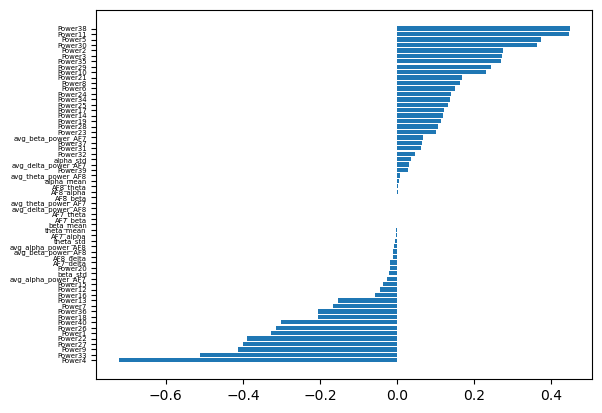

Linear SVM yields accuracy of 0.65


In [17]:
# SVMs take long time to run!
names = [
#     'XGBoost',
#     "Adaboost",
#     "RandomForest",
#     "GradientBoost",
#     'Nearest Neighbors',
#     'LDA',
#     'RBF SVM',
    "Linear SVM",
]

acc_res = {}
for name in names:
    accuracy_lst = []
    for _ in range(number_of_folds):
        if name == "Adaboost":
            clf = AdaBoostClassifier()
        if name == "RandomForest":
            clf = RandomForestClassifier(n_estimators=100, max_features="sqrt", oob_score=True)
        if name == "GradientBoost":
            clf = GradientBoostingClassifier()
        if name == 'Nearest Neighbors':
            clf = KNeighborsClassifier(n_neighbors=number_of_neighbors)
        if name == "LDA":
            clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        if name == "RBF SVM":
            clf = SVC(gamma=2, C=1)
        if name == "Linear SVM":
            clf = SVC(kernel="linear", C=0.025)
        if name == "XGBoost":
            clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric='mlogloss', random_state=42, use_label_encoder=False)
        train_data = pd.concat(folds_concat[:-1], ignore_index=True)
        # take the last fold as the test set
        test_data = folds_concat[-1]
        # move the last fold to the beginning of the list of folds
        folds_concat = folds_concat[-1:] + folds_concat[:-1]
        train_X = train_data.iloc[:, :-1]
        train_Y = train_data.iloc[:, -1]
        test_X = test_data.iloc[:, :-1]
        test_Y = test_data.iloc[:, -1]
        clf.fit(train_X, train_Y)
        y_predict = clf.predict(test_X)
        accuracy = metrics.accuracy_score(y_predict,test_Y)
        accuracy_lst.append(accuracy)
    if name == "Linear SVM":
        f_importances(clf.coef_[0], clf.feature_names_in_)
    avg_acc = round(sum(accuracy_lst) / len(accuracy_lst),3)
    acc_res[name] = avg_acc
    print(f"{name} yields accuracy of {avg_acc}")



In [18]:
acc_res

{'Linear SVM': 0.65}